In [1]:
import pandas as pd

# Load the datasets
day_ahead_prices_df = pd.read_csv('Day-ahead_Prices_2018-2023_BEST.csv')
generation_forecasts_df = pd.read_csv('complete_generation_forecasts_with_lstm_predictions.csv')

# Display the first few rows of each dataset
day_ahead_prices_df.head(), generation_forecasts_df.head()


(                  Time  Day-ahead Price [EUR/MWh]
 0  2018-10-01 11:00:00                     100.00
 1  2018-10-02 11:00:00                      72.22
 2  2018-10-03 11:00:00                      80.61
 3  2018-10-04 11:00:00                      71.60
 4  2018-10-05 11:00:00                      80.55,
          Time  Wind Offshore  [MW] Day Ahead
 0  2018-01-01                    2158.083333
 1  2018-01-02                    2236.125000
 2  2018-01-03                    2715.500000
 3  2018-01-04                    1274.583333
 4  2018-01-05                     464.083333)

In [2]:
# Convert the 'Time' columns to datetime format
day_ahead_prices_df['Time'] = pd.to_datetime(day_ahead_prices_df['Time'])
generation_forecasts_df['Time'] = pd.to_datetime(generation_forecasts_df['Time'])

# Merge the datasets on 'Time' column
merged_df = pd.merge(day_ahead_prices_df, generation_forecasts_df, on='Time', how='inner')

# Check for missing values
missing_values = merged_df.isnull().sum()

# Summary statistics
summary_statistics = merged_df.describe()

missing_values, summary_statistics


(Time                             0.0
 Day-ahead Price [EUR/MWh]        0.0
 Wind Offshore  [MW] Day Ahead    0.0
 dtype: float64,
        Day-ahead Price [EUR/MWh]  Wind Offshore  [MW] Day Ahead
 count                        0.0                            0.0
 mean                         NaN                            NaN
 std                          NaN                            NaN
 min                          NaN                            NaN
 25%                          NaN                            NaN
 50%                          NaN                            NaN
 75%                          NaN                            NaN
 max                          NaN                            NaN)

In [3]:
# Check the range of dates in both datasets
day_ahead_prices_date_range = (day_ahead_prices_df['Time'].min(), day_ahead_prices_df['Time'].max())
generation_forecasts_date_range = (generation_forecasts_df['Time'].min(), generation_forecasts_df['Time'].max())

day_ahead_prices_date_range, generation_forecasts_date_range


((Timestamp('2018-10-01 11:00:00'), Timestamp('2023-05-31 11:00:00')),
 (Timestamp('2018-01-01 00:00:00'), Timestamp('2023-04-06 00:00:00')))

In [4]:
# Normalize the 'Time' columns by removing the time component
day_ahead_prices_df['Time'] = day_ahead_prices_df['Time'].dt.normalize()
generation_forecasts_df['Time'] = generation_forecasts_df['Time'].dt.normalize()

# Merge the datasets on 'Time' column again
merged_df = pd.merge(day_ahead_prices_df, generation_forecasts_df, on='Time', how='inner')

# Check for missing values
missing_values = merged_df.isnull().sum()

# Summary statistics
summary_statistics = merged_df.describe()

missing_values, summary_statistics


(Time                             0
 Day-ahead Price [EUR/MWh]        0
 Wind Offshore  [MW] Day Ahead    0
 dtype: int64,
        Day-ahead Price [EUR/MWh]  Wind Offshore  [MW] Day Ahead
 count                1649.000000                    1649.000000
 mean                  124.117476                    1610.329996
 std                    98.814219                    1056.237342
 min                    -5.180000                      53.000000
 25%                    49.790000                     716.916667
 50%                    80.610000                    1405.583333
 75%                   184.076951                    2343.916667
 max                   600.000000                    5050.000000)

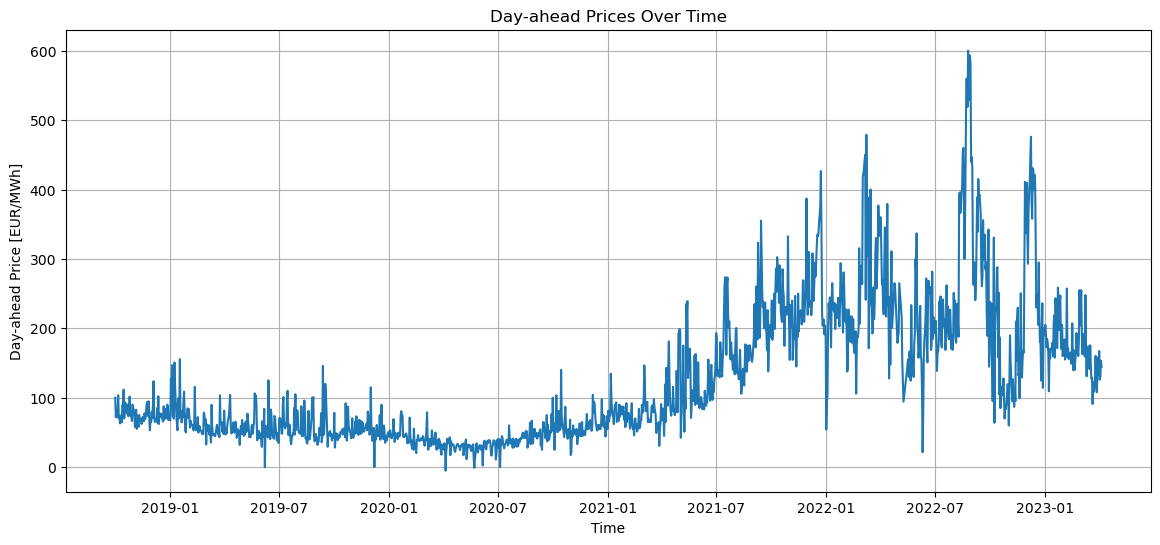

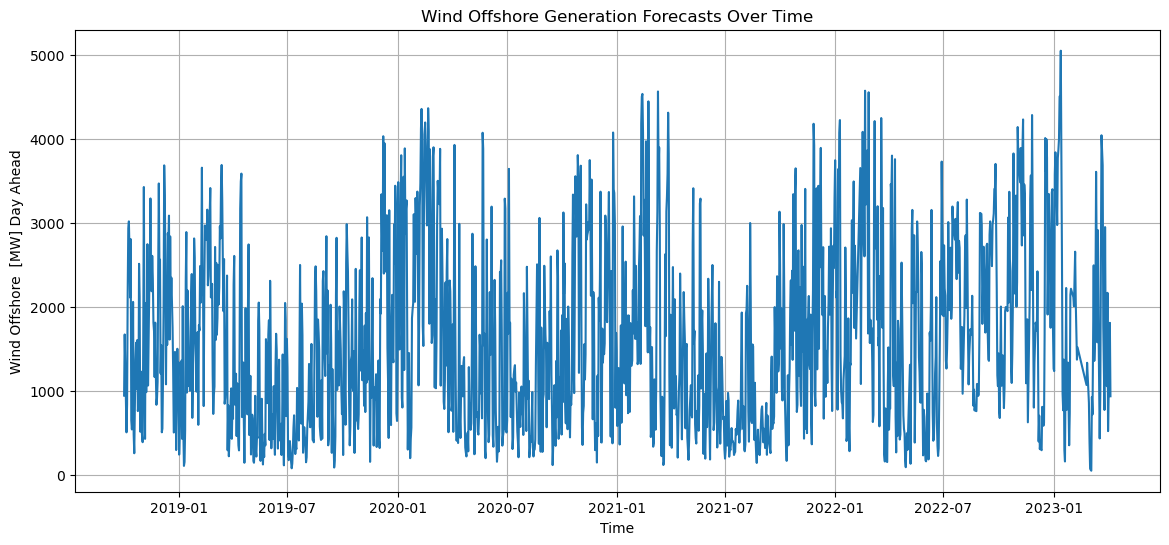

In [5]:
import matplotlib.pyplot as plt

# Plotting the day-ahead prices
plt.figure(figsize=(14, 6))
plt.plot(merged_df['Time'], merged_df['Day-ahead Price [EUR/MWh]'])
plt.title('Day-ahead Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Day-ahead Price [EUR/MWh]')
plt.grid(True)
plt.show()

# Plotting the generation forecasts
plt.figure(figsize=(14, 6))
plt.plot(merged_df['Time'], merged_df['Wind Offshore  [MW] Day Ahead'])
plt.title('Wind Offshore Generation Forecasts Over Time')
plt.xlabel('Time')
plt.ylabel('Wind Offshore  [MW] Day Ahead')
plt.grid(True)
plt.show()


In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

# Filter data up to 2022 for training and validation
filtered_df = merged_df[merged_df['Time'] <= '2022-12-31']

# Split the data into training and test sets
train_df = filtered_df[filtered_df['Time'] < '2021-01-01']
test_df = filtered_df[filtered_df['Time'] >= '2021-01-01']

# Define the endogenous and exogenous variables
endog_train = train_df['Day-ahead Price [EUR/MWh]']
exog_train = train_df['Wind Offshore  [MW] Day Ahead']
endog_test = test_df['Day-ahead Price [EUR/MWh]']
exog_test = test_df['Wind Offshore  [MW] Day Ahead']

# Define the SARIMAX model
# We will start with a simple model with order (1, 1, 1) and seasonal order (0, 0, 0, 0)
model = SARIMAX(endog=endog_train, exog=exog_train, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))

# Fit the model
model_fit = model.fit(disp=False)

# Make predictions
predictions = model_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1, exog=exog_test)

# Calculate RMSE
rmse = sqrt(mean_squared_error(endog_test, predictions))

rmse


163.3333395535747

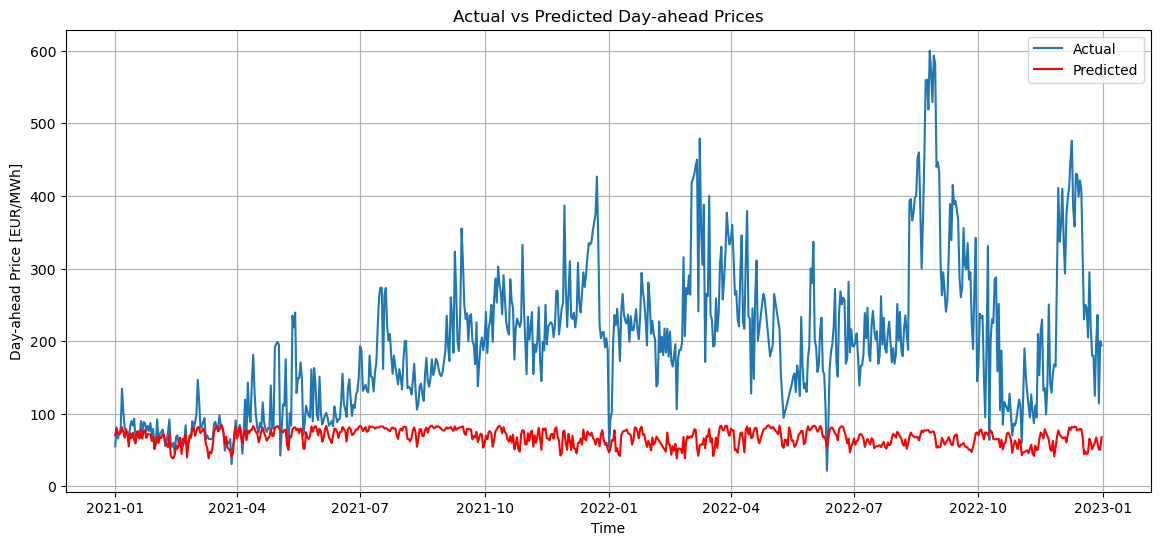

In [7]:
# Plotting the actual vs predicted values
plt.figure(figsize=(14, 6))
plt.plot(test_df['Time'], endog_test, label='Actual')
plt.plot(test_df['Time'], predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted Day-ahead Prices')
plt.xlabel('Time')
plt.ylabel('Day-ahead Price [EUR/MWh]')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

# Create a new feature for the day of the year
train_df['Day_of_Year'] = train_df['Time'].dt.dayofyear
test_df['Day_of_Year'] = test_df['Time'].dt.dayofyear

# Define the features and target variables
features_train = train_df[['Wind Offshore  [MW] Day Ahead', 'Day_of_Year']]
target_train = train_df['Day-ahead Price [EUR/MWh]']
features_test = test_df[['Wind Offshore  [MW] Day Ahead', 'Day_of_Year']]
target_test = test_df['Day-ahead Price [EUR/MWh]']

# Standardize the features
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

# Define the XGBoost model
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)

# Fit the model
xgb_model.fit(features_train_scaled, target_train, 
              early_stopping_rounds=5, 
              eval_set=[(features_test_scaled, target_test)], 
              verbose=False)

# Make predictions
xgb_predictions = xgb_model.predict(features_test_scaled)

# Calculate RMSE
xgb_rmse = sqrt(mean_squared_error(target_test, xgb_predictions))

xgb_rmse


C:\Users\ridva\AppData\Local\Temp\ipykernel_86848\1993325827.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Day_of_Year'] = train_df['Time'].dt.dayofyear
C:\Users\ridva\AppData\Local\Temp\ipykernel_86848\1993325827.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Day_of_Year'] = test_df['Time'].dt.dayofyear
C:\Users\ridva\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn

177.1452234811881

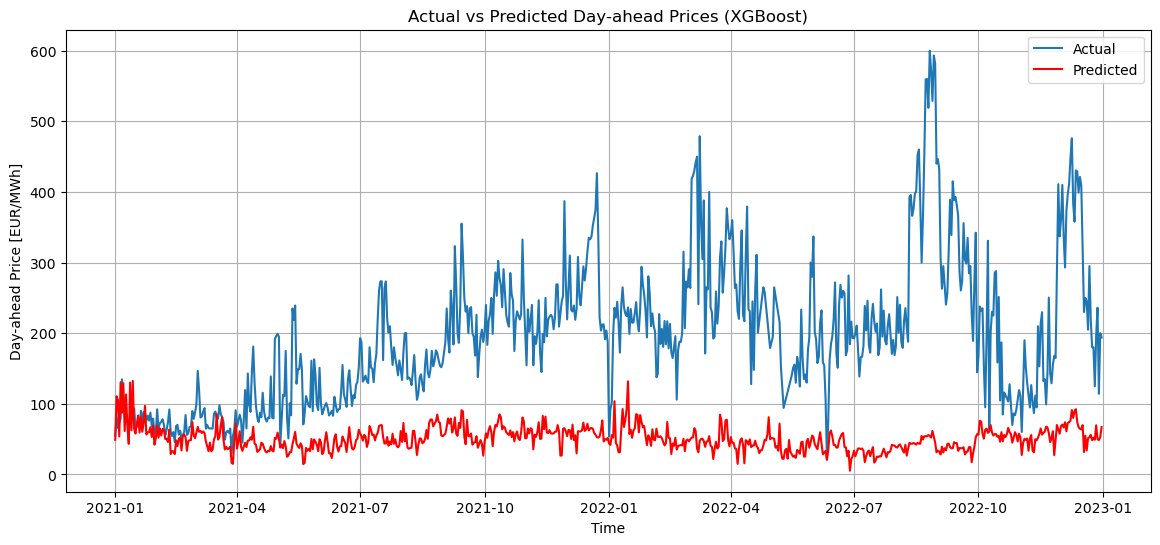

In [9]:
# Plotting the actual vs predicted values for XGBoost model
plt.figure(figsize=(14, 6))
plt.plot(test_df['Time'], target_test, label='Actual')
plt.plot(test_df['Time'], xgb_predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted Day-ahead Prices (XGBoost)')
plt.xlabel('Time')
plt.ylabel('Day-ahead Price [EUR/MWh]')
plt.legend()
plt.grid(True)
plt.show()


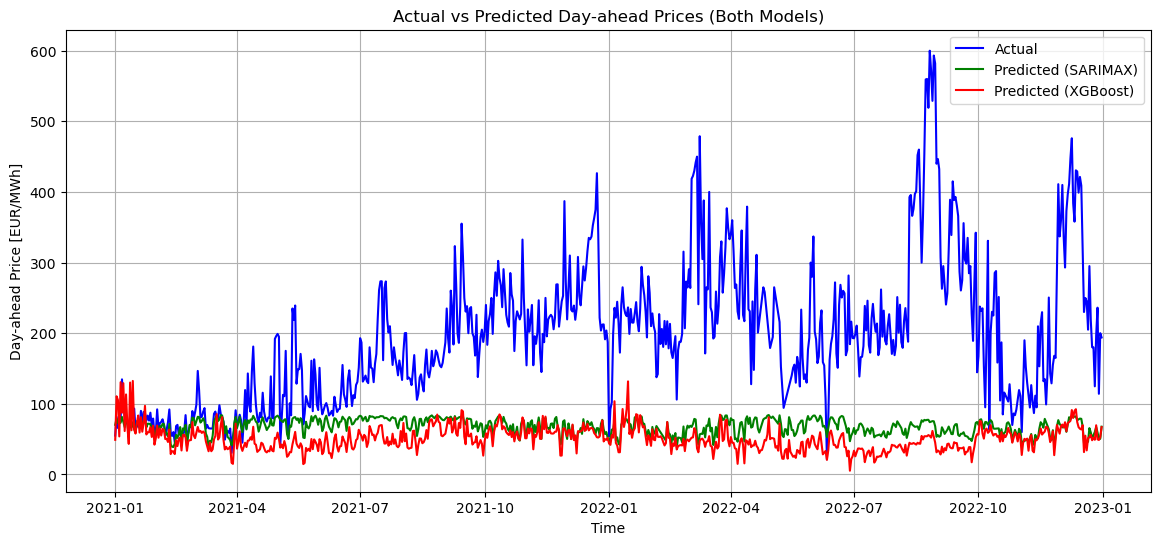

[55.02, 81.36, 65.76, 73.0, 79.0, 134.63, 103.0, 81.54, 73.72, 74.93]
        
[70.29464191429574, 79.17653623758986, 72.884881752894, 72.10365720740103, 73.29009823422457, 81.37820950894651, 74.46499095014795, 66.93537022084601, 78.74171023329994, 71.40623880222269]
        
[48.994781494140625, 110.69258880615234, 105.26994323730469, 53.823951721191406, 130.6097412109375, 87.38941955566406, 129.17335510253906, 61.45322036743164, 113.27935791015625, 68.31752014160156]
        


In [10]:
# Plotting the actual vs predicted values for both models
plt.figure(figsize=(14, 6))

plt.plot(test_df['Time'], target_test, label='Actual', color='blue')
plt.plot(test_df['Time'], predictions, label='Predicted (SARIMAX)', color='green')
plt.plot(test_df['Time'], xgb_predictions, label='Predicted (XGBoost)', color='red')

plt.title('Actual vs Predicted Day-ahead Prices (Both Models)')
plt.xlabel('Time')
plt.ylabel('Day-ahead Price [EUR/MWh]')
plt.legend()
plt.grid(True)
plt.show()

# Convert predictions to lists for comparison
sarimax_predictions_list = predictions.tolist()
xgboost_predictions_list = xgb_predictions.tolist()
actual_values_list = target_test.tolist()

# Displaying first 5 predictions
print(actual_values_list[:10]) 
print("        ")
print(sarimax_predictions_list[:10]) 
print("        ")
print(xgboost_predictions_list[:10])
print("        ")
